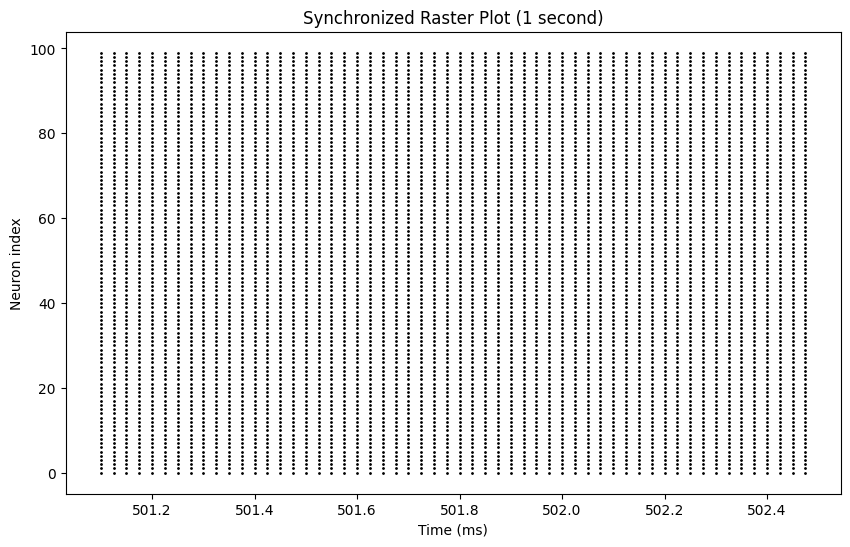

In [10]:
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

# Number of neurons
n_neurons = 100

# Create neurons
neurons = []
for i in range(n_neurons):
    neuron = h.Section(name=f'neuron_{i}')
    neuron.L = neuron.diam = 12.6157
    neuron.insert('hh')
    neurons.append(neuron)

# Create synapses and strong common input
synapses = []
connections = []
stim_common = h.NetStim()  # Shared stimulus
stim_common.number = 1
stim_common.start = 500  # Single pulse at the middle of the 1-second window

# Connect all neurons to the shared stimulus
for neuron in neurons:
    syn = h.ExpSyn(neuron(0.5))
    conn = h.NetCon(stim_common, syn)
    conn.weight[0] = 2  # Stronger input to cause synchronization
    synapses.append(syn)
    connections.append(conn)

# Add some random recurrent connectivity
for i, pre_neuron in enumerate(neurons):
    for j, post_neuron in enumerate(neurons):
        if i != j and np.random.rand() < 0.2:  # 20% connectivity
            syn = h.ExpSyn(post_neuron(0.5))
            pre_neuron.push()
            conn = h.NetCon(pre_neuron(0.5)._ref_v, syn)
            h.pop_section()
            conn.threshold = -20
            conn.weight[0] = 0.1  # Small recurrent weight
            synapses.append(syn)
            connections.append(conn)

# Record activity
t_vec = h.Vector()
t_vec.record(h._ref_t)
v_vecs = [h.Vector().record(neuron(0.5)._ref_v) for neuron in neurons]

# Run simulation
h.load_file('stdrun.hoc')  # Ensures that standard run procedures like 'tstop' are available
h.tstop = 1000  # 1 second = 1000 ms
h.run()

# Detect spike times (raster plot preparation)
spike_threshold = 0  # Voltage threshold for detecting spikes
spike_times = []
spike_indices = []

for i, v_vec in enumerate(v_vecs):
    times = np.array(t_vec)
    voltages = np.array(v_vec)
    spikes = times[voltages > spike_threshold]
    spike_times.extend(spikes)
    spike_indices.extend([i] * len(spikes))

# Generate raster plot
plt.figure(figsize=(10, 6))
plt.scatter(spike_times, spike_indices, s=1, c="black")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron index")
plt.title("Synchronized Raster Plot (1 second)")
plt.show()